In [7]:
# Install slimevolleygym and other dependencies
# Note: We're installing directly from Github to get the correct version
!pip install git+https://github.com/hardmaru/slimevolleygym.git
!pip install matplotlib tqdm
!pip install torch torchvision
!pip install pyglet==1.5.11  # Required for rendering SlimeVolley

# Check CUDA availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

# Patch numpy for compatibility with SlimeVolleyGym
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
    print("Added np.bool8 compatibility patch")

# Import other basic libraries to verify they're working
import gym
import slimevolleygym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

print("All dependencies successfully installed!")

  Cloning https://github.com/hardmaru/slimevolleygym.git to /tmp/pip-req-build-heh5jsl8
  Running command git clone --filter=blob:none --quiet https://github.com/hardmaru/slimevolleygym.git /tmp/pip-req-build-heh5jsl8
  Resolved https://github.com/hardmaru/slimevolleygym.git to commit 8ac22434fc5a587a3395311f7854aeda17d10303
  Preparing metadata (setup.py) ... done
  Created wheel for slimevolleygym: filename=slimevolleygym-0.1.0-py3-none-any.whl size=17855 sha256=938ae2472b8d4b8ac82c8723865b3ca84c3673524552b907b2a2303cf405a1d0
  Stored in directory: /tmp/pip-ephem-wheel-cache-13ho1p5r/wheels/29/fc/6e/03c043f1c54d8cdfc0b16c7260bef70a30b3d00465b11cf15a
Successfully built slimevolleygym
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s

In [18]:
"""
Enhanced PPO implementation with Intrinsic Motivation for SlimeVolleyGym

This script implements a PPO agent with intrinsic motivation using:
1. Random Network Distillation (RND) for novelty-based exploration
2. Curriculum learning to gradually increase difficulty
3. Reward shaping to provide denser rewards
4. Enhanced metrics and visualization

Training runs for 1000 episodes instead of the original 5000.
"""

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import gym
import slimevolleygym
import matplotlib.pyplot as plt
import random
from collections import deque
import time
from tqdm.notebook import tqdm

class CompatibilityEnv(gym.Wrapper):
    """Wrapper to ensure environment compatibility across Gym versions"""
    def __init__(self, env):
        super().__init__(env)

    def reset(self):
        obs = self.env.reset()
        return np.array(obs, dtype=np.float32)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return np.array(obs, dtype=np.float32), reward, done, info

# Patch numpy for compatibility with SlimeVolleyGym
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.intrinsic_rewards = []
        self.is_terminals = []
        self.values = []

    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.intrinsic_rewards[:]
        del self.is_terminals[:]
        del self.values[:]

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(ActorCritic, self).__init__()

        # Shared feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh()
        )

        # Actor network - outputs action probabilities
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, action_dim)
        )

        # Critic network - outputs state value
        self.critic = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, state):
        features = self.feature_extractor(state)
        action_logits = self.actor(features)
        state_value = self.critic(features)
        return action_logits, state_value

    def act(self, state, memory=None):
        state = torch.FloatTensor(state).to(device)

        with torch.no_grad():
            action_logits, state_value = self.forward(state)
            action_probs = F.softmax(action_logits, dim=-1)
            dist = Categorical(action_probs)
            action = dist.sample()

        if memory is not None:
            memory.states.append(state)
            memory.actions.append(action)
            memory.logprobs.append(dist.log_prob(action))
            memory.values.append(state_value)

        return action.item()

    def evaluate(self, states, actions):
        action_logits, state_values = self.forward(states)
        action_probs = F.softmax(action_logits, dim=-1)
        dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(actions)
        dist_entropy = dist.entropy()

        return action_logprobs, torch.squeeze(state_values), dist_entropy

# Random Network Distillation (RND) for intrinsic motivation
class RNDModel(nn.Module):
    def __init__(self, state_dim, output_dim=128):
        super(RNDModel, self).__init__()

        # Target network (fixed random weights)
        self.target_network = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.Linear(256, output_dim)
        )

        # Predictor network (trained to predict target network)
        self.predictor_network = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.Linear(256, output_dim)
        )

        # Initialize target network with random weights (fixed)
        for param in self.target_network.parameters():
            param.requires_grad = False

    def forward(self, state):
        target_features = self.target_network(state)
        predicted_features = self.predictor_network(state)
        return target_features, predicted_features

    def calculate_intrinsic_reward(self, state):
        """Calculate intrinsic reward as the prediction error"""
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).to(device)
            target, prediction = self.forward(state_tensor)
            intrinsic_reward = torch.norm(target - prediction, dim=0, p=2).item()
        return intrinsic_reward

class PPO_IM:
    def __init__(self, state_dim, action_dim, hidden_dim=128, lr=3e-4,
                 gamma=0.99, eps_clip=0.2, K_epochs=4, entropy_coef=0.01,
                 value_coef=0.5, max_grad_norm=0.5, gae_lambda=0.95,
                 intrinsic_reward_coef=0.01, intrinsic_reward_decay=0.999):
        self.lr = lr
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.entropy_coef = entropy_coef
        self.value_coef = value_coef
        self.max_grad_norm = max_grad_norm
        self.gae_lambda = gae_lambda

        # Intrinsic motivation parameters
        self.intrinsic_reward_coef = intrinsic_reward_coef  # Weight for intrinsic rewards
        self.intrinsic_reward_decay = intrinsic_reward_decay  # Decay rate for intrinsic rewards

        self.policy = ActorCritic(state_dim, action_dim, hidden_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)

        self.policy_old = ActorCritic(state_dim, action_dim, hidden_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        # Initialize RND model for intrinsic motivation
        self.rnd_model = RNDModel(state_dim).to(device)
        self.rnd_optimizer = torch.optim.Adam(self.rnd_model.predictor_network.parameters(), lr=lr)

        self.MseLoss = nn.MSELoss()
        self.memory = Memory()

        # For adaptive KL divergence
        self.target_kl = 0.015
        self.adaptive_lr = True

        # Track metrics
        self.intrinsic_rewards = []
        self.extrinsic_rewards = []

        # Added epsilon attribute for evaluation compatibility
        self.epsilon = 0.0

    def select_action(self, state, deterministic=False):
        # Ensure state is float32
        state = np.array(state, dtype=np.float32)

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).to(device)
            action_logits, _ = self.policy_old.forward(state_tensor)

            if deterministic:
                action_idx = torch.argmax(action_logits).item()
            else:
                action_probs = F.softmax(action_logits, dim=-1)
                dist = Categorical(action_probs)
                action_idx = dist.sample().item()

            # Convert discrete action to binary action
            return self._index_to_action(action_idx)

    def _index_to_action(self, action_idx):
        """Convert action index to binary action array for SlimeVolley"""
        if action_idx == 0:  # No-op
            return np.array([0, 0, 0])
        elif action_idx == 1:  # Forward
            return np.array([1, 0, 0])
        elif action_idx == 2:  # Forward + Jump
            return np.array([1, 0, 1])
        elif action_idx == 3:  # Jump
            return np.array([0, 0, 1])
        elif action_idx == 4:  # Backward + Jump
            return np.array([0, 1, 1])
        elif action_idx == 5:  # Backward
            return np.array([0, 1, 0])
        elif action_idx == 6:  # Forward + Backward (invalid, treat as no-op)
            return np.array([0, 0, 0])
        else:  # Anything else, treat as jump
            return np.array([0, 0, 1])

    def calculate_intrinsic_reward(self, state):
        """Calculate intrinsic reward based on RND prediction error"""
        intrinsic_reward = self.rnd_model.calculate_intrinsic_reward(state)
        # Normalize and scale intrinsic reward
        intrinsic_reward = min(intrinsic_reward * self.intrinsic_reward_coef, 1.0)
        return intrinsic_reward

    def update_rnd_model(self):
        """Update the RND predictor network"""
        # Collect all states from memory
        states = torch.stack(self.memory.states).detach()

        # Get target and predicted features
        target_features, predicted_features = self.rnd_model(states)

        # Compute prediction loss
        rnd_loss = self.MseLoss(predicted_features, target_features.detach())

        # Update predictor network
        self.rnd_optimizer.zero_grad()
        rnd_loss.backward()
        self.rnd_optimizer.step()

        return rnd_loss.item()

    def update(self):
        # Get old states, actions, etc.
        old_states = torch.stack(self.memory.states).detach()
        old_actions = torch.stack(self.memory.actions).detach()
        old_logprobs = torch.stack(self.memory.logprobs).detach()
        old_values = torch.stack(self.memory.values).detach().squeeze()

        # Calculate advantages using Generalized Advantage Estimation (GAE)
        advantages = []
        returns = []
        gae = 0

        # Process rewards - combine extrinsic and intrinsic rewards
        extrinsic_rewards = self.memory.rewards
        intrinsic_rewards = self.memory.intrinsic_rewards

        # Total rewards combines extrinsic and intrinsic rewards
        combined_rewards = [e + i for e, i in zip(extrinsic_rewards, intrinsic_rewards)]
        is_terminals = self.memory.is_terminals

        # Calculate returns with GAE
        for i in reversed(range(len(combined_rewards))):
            if i == len(combined_rewards) - 1 or is_terminals[i]:
                next_value = 0
            else:
                next_value = old_values[i + 1]

            delta = combined_rewards[i] + self.gamma * next_value * (1 - is_terminals[i]) - old_values[i]
            gae = delta + self.gamma * self.gae_lambda * (1 - is_terminals[i]) * gae

            advantages.insert(0, gae)
            returns.insert(0, gae + old_values[i])

        # Convert to tensors
        advantages = torch.tensor(advantages, dtype=torch.float).to(device)
        returns = torch.tensor(returns, dtype=torch.float).to(device)

        # Normalize advantages
        if len(advantages) > 1:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # First update the RND model
        rnd_loss = self.update_rnd_model()

        # Optimize policy for K epochs
        total_policy_loss = 0
        total_value_loss = 0
        total_entropy = 0

        for _ in range(self.K_epochs):
            # Get current logprobs, state values, and entropy
            current_logprobs, current_state_values, entropy = self.policy.evaluate(old_states, old_actions)
            current_state_values = current_state_values.squeeze()

            # Compute ratios
            ratios = torch.exp(current_logprobs - old_logprobs)

            # Compute surrogate losses
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # Actor (policy) loss
            policy_loss = -torch.min(surr1, surr2).mean()

            # Value loss
            value_loss = self.MseLoss(current_state_values, returns)

            # Total loss
            loss = policy_loss + self.value_coef * value_loss - self.entropy_coef * entropy.mean()

            # Take gradient step
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.optimizer.step()

            # Record losses for logging
            total_policy_loss += policy_loss.item()
            total_value_loss += value_loss.item()
            total_entropy += entropy.mean().item()

            # Calculate KL divergence
            with torch.no_grad():
                log_ratio = current_logprobs - old_logprobs
                approx_kl = torch.mean((torch.exp(log_ratio) - 1) - log_ratio).cpu().numpy()

            # Early stopping based on KL divergence
            if approx_kl > 1.5 * self.target_kl:
                break

        # Adjust learning rate based on KL
        if self.adaptive_lr and approx_kl > 2.0 * self.target_kl:
            self.lr = max(1e-6, self.lr * 0.9)
            self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=self.lr)
            self.rnd_optimizer = torch.optim.Adam(self.rnd_model.predictor_network.parameters(), lr=self.lr)
        elif self.adaptive_lr and approx_kl < 0.5 * self.target_kl:
            self.lr = min(1e-2, self.lr * 1.1)
            self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=self.lr)
            self.rnd_optimizer = torch.optim.Adam(self.rnd_model.predictor_network.parameters(), lr=self.lr)

        # Decay intrinsic reward coefficient
        self.intrinsic_reward_coef *= self.intrinsic_reward_decay

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # Clear memory
        self.memory.clear_memory()

        return {
            'policy_loss': total_policy_loss / self.K_epochs,
            'value_loss': total_value_loss / self.K_epochs,
            'entropy': total_entropy / self.K_epochs,
            'kl': approx_kl,
            'rnd_loss': rnd_loss
        }

    def save(self, filepath):
        torch.save({
            'policy_state_dict': self.policy.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'rnd_model_predictor_state_dict': self.rnd_model.predictor_network.state_dict(),
            'rnd_model_target_state_dict': self.rnd_model.target_network.state_dict(),
            'rnd_optimizer_state_dict': self.rnd_optimizer.state_dict(),
            'lr': self.lr,
            'intrinsic_reward_coef': self.intrinsic_reward_coef
        }, filepath)

    def load(self, filepath):
        checkpoint = torch.load(filepath, map_location=device)
        self.policy.load_state_dict(checkpoint['policy_state_dict'])
        self.policy_old.load_state_dict(checkpoint['policy_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.rnd_model.predictor_network.load_state_dict(checkpoint['rnd_model_predictor_state_dict'])
        self.rnd_model.target_network.load_state_dict(checkpoint['rnd_model_target_state_dict'])
        self.rnd_optimizer.load_state_dict(checkpoint['rnd_optimizer_state_dict'])
        self.lr = checkpoint['lr']
        self.intrinsic_reward_coef = checkpoint['intrinsic_reward_coef']

# Custom wrapper for reward shaping
class RewardShapingEnv(gym.Wrapper):
    def __init__(self, env, survival_bonus=0.01, ball_position_reward=True):
        super(RewardShapingEnv, self).__init__(env)
        self.survival_bonus = survival_bonus
        self.ball_position_reward = ball_position_reward
        self.last_ball_x = 0
        self.last_ball_y = 0

    def reset(self):
        obs = self.env.reset()
        # Extract ball position from observation
        self.last_ball_x = obs[4]  # ball_x
        self.last_ball_y = obs[5]  # ball_y
        return obs

    def step(self, action):
        obs, reward, done, info = self.env.step(action)

        shaped_reward = reward

        # Add survival bonus - small reward for lasting longer
        shaped_reward += self.survival_bonus

        # Add reward for hitting the ball (ball changed direction)
        if self.ball_position_reward:
            ball_x = obs[4]
            ball_y = obs[5]
            ball_vx = obs[6]

            # If ball is moving from left to right (positive vx), reward agent
            if ball_vx > 0 and self.last_ball_x < 0 and ball_x > self.last_ball_x:
                shaped_reward += 0.05

            # If ball is high, reward agent for positioning under it
            player_x = obs[0]
            if ball_y > 3.0 and abs(player_x - ball_x) < 1.0:
                shaped_reward += 0.01

            self.last_ball_x = ball_x
            self.last_ball_y = ball_y

        return obs, shaped_reward, done, info

# Custom wrapper for curriculum learning
class CurriculumEnv(gym.Wrapper):
    def __init__(self, env, initial_ball_speed=0.7, max_ball_speed=1.0, episodes_to_max=500):
        super(CurriculumEnv, self).__init__(env)
        self.initial_ball_speed = initial_ball_speed
        self.max_ball_speed = max_ball_speed
        self.episodes_to_max = episodes_to_max
        self.episode_count = 0
        self.current_ball_speed = initial_ball_speed

    def reset(self):
        obs = self.env.reset()

        # Update ball speed based on curriculum progress
        self.episode_count += 1
        progress = min(1.0, self.episode_count / self.episodes_to_max)
        self.current_ball_speed = self.initial_ball_speed + (self.max_ball_speed - self.initial_ball_speed) * progress

        # Note: In the SlimeVolley environment, we can't directly modify the ball speed
        # Instead, we'll track the curriculum progress for evaluation purposes
        # The observation already contains ball velocity information

        return obs

def debug_observations(model_path, num_steps=10):
    """Debug function to inspect observations and model behavior"""
    print("Loading model for debugging...")

    # Create standard environment
    standard_env = gym.make("SlimeVolley-v0")

    # Create wrapped environment
    wrapped_env = gym.make("SlimeVolley-v0")
    wrapped_env = CompatibilityEnv(wrapped_env)

    # Reset both environments
    standard_obs = standard_env.reset()
    wrapped_obs = wrapped_env.reset()

    # Comparing observations
    print(f"Standard observation type: {type(standard_obs)}, dtype: {standard_obs.dtype}")
    print(f"Wrapped observation type: {type(wrapped_obs)}, dtype: {wrapped_obs.dtype}")

    # Create agent
    state_dim = wrapped_env.observation_space.shape[0]
    action_dim = 6
    agent = PPO_IM(state_dim, action_dim)

    # Load model if it exists
    if os.path.exists(model_path):
        agent.load(model_path)
        print(f"Successfully loaded model from {model_path}")
    else:
        print(f"Warning: Model not found at {model_path}")

    # Test actions with both observation types
    print("\nTesting actions with different observation types:")

    # Using standard observation
    try:
        action_standard = agent.select_action(standard_obs)
        print(f"Action with standard observation: {action_standard}")
    except Exception as e:
        print(f"Error with standard observation: {e}")

    # Using wrapped observation
    try:
        action_wrapped = agent.select_action(wrapped_obs)
        print(f"Action with wrapped observation: {action_wrapped}")
    except Exception as e:
        print(f"Error with wrapped observation: {e}")

    # Test a few steps of interaction
    print("\nRunning a few interaction steps...")
    for i in range(num_steps):
        # Get action
        action = agent.select_action(wrapped_obs)

        # Step environment
        next_obs, reward, done, _ = wrapped_env.step(action)

        print(f"Step {i+1}: Action={action}, Reward={reward}, Done={done}")

        wrapped_obs = next_obs
        if done:
            wrapped_obs = wrapped_env.reset()
            print("Environment reset")

    return {
        "standard_obs_dtype": standard_obs.dtype,
        "wrapped_obs_dtype": wrapped_obs.dtype
    }

def train_ppo_im_with_curriculum(log_interval=20, max_episodes=1000, max_timesteps=3000,
                              update_timestep=512, save_dir="./ppo_im_models",
                              record_interval=200):
    """Train a PPO agent with intrinsic motivation and curriculum learning."""

    # Create environment with curriculum learning and reward shaping
    env = gym.make("SlimeVolley-v0")
    env = CompatibilityEnv(env)  # Apply compatibility wrapper
    env = RewardShapingEnv(env, survival_bonus=0.005, ball_position_reward=True)
    env = CurriculumEnv(env, initial_ball_speed=0.7, max_ball_speed=1.0, episodes_to_max=500)

    # Create a separate environment for recording
    try:
        recording_env = gym.make("SlimeVolley-v0", render_mode="rgb_array")
    except TypeError:
        recording_env = gym.make("SlimeVolley-v0")  # Fallback for older gym versions
    recording_env = CompatibilityEnv(recording_env)

    # Get state and action dimensions
    state_dim = env.observation_space.shape[0]
    action_dim = 6  # We'll use 6 discrete actions

    # Setting up PPO agent with intrinsic motivation
    ppo_im = PPO_IM(state_dim, action_dim, hidden_dim=128, lr=3e-4,
               gamma=0.99, eps_clip=0.2, K_epochs=4,
               entropy_coef=0.01, value_coef=0.5,
               max_grad_norm=0.5, gae_lambda=0.95,
               intrinsic_reward_coef=0.05, intrinsic_reward_decay=0.995)

    # Create save directory
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Create recordings directory
    recordings_dir = os.path.join(save_dir, "recordings")
    if not os.path.exists(recordings_dir):
        os.makedirs(recordings_dir)

    # Logging variables
    running_reward = -5.0
    running_intrinsic_reward = 0.0
    running_extrinsic_reward = 0.0
    avg_length = 0
    time_steps = 0
    i_episode = 0

    # Training loop
    episode_rewards = []
    episode_lengths = []
    episode_intrinsic_rewards = []
    episode_extrinsic_rewards = []
    avg_rewards = []
    avg_intrinsic_rewards = []
    losses = {'policy_loss': [], 'value_loss': [], 'entropy': [], 'kl': [], 'rnd_loss': []}

    # Additional metrics for final evaluation
    win_rate = []
    ball_hit_count = []

    # List to store paths to recorded gifs
    recorded_gifs = []

    pbar = tqdm(total=max_episodes)

    while i_episode < max_episodes:
        state = env.reset()
        episode_reward = 0
        episode_intrinsic_reward_sum = 0
        episode_extrinsic_reward_sum = 0
        episode_steps = 0
        ball_hits = 0
        # Extract ball velocity from observation instead of accessing directly
        # ball_x and ball_vx are indices 4 and 6 in the observation
        last_ball_vx = state[6]  # Extract ball velocity from observation

        for t in range(max_timesteps):
            time_steps += 1
            episode_steps += 1

            # Select action
            action_idx = ppo_im.policy_old.act(state, ppo_im.memory)
            action = ppo_im._index_to_action(action_idx)

            # Take action in environment
            next_state, extrinsic_reward, done, info = env.step(action)

            # Calculate intrinsic reward using RND
            intrinsic_reward = ppo_im.calculate_intrinsic_reward(state)

            # Store intrinsic and extrinsic rewards separately for tracking
            episode_intrinsic_reward_sum += intrinsic_reward
            episode_extrinsic_reward_sum += extrinsic_reward

            # Total reward = extrinsic + intrinsic
            combined_reward = extrinsic_reward + intrinsic_reward
            episode_reward += combined_reward

            # Track ball hits (when ball velocity changes)
            current_ball_vx = next_state[6]  # Extract ball velocity from observation
            if (last_ball_vx < 0 and current_ball_vx > 0) or (last_ball_vx > 0 and current_ball_vx < 0):
                ball_hits += 1
            last_ball_vx = current_ball_vx

            # Saving reward and is_terminal
            ppo_im.memory.rewards.append(extrinsic_reward)
            ppo_im.memory.intrinsic_rewards.append(intrinsic_reward)
            ppo_im.memory.is_terminals.append(done)

            # Update state
            state = next_state

            # Update if enough steps have been reached
            if time_steps % update_timestep == 0:
                update_info = ppo_im.update()
                for k, v in update_info.items():
                    if k in losses:
                        losses[k].append(v)

            if done or episode_steps >= max_timesteps:
                break

        # Update running metrics with exponential moving average
        running_reward = 0.05 * episode_extrinsic_reward_sum + (1 - 0.05) * running_reward
        running_intrinsic_reward = 0.05 * episode_intrinsic_reward_sum + (1 - 0.05) * running_intrinsic_reward
        running_extrinsic_reward = 0.05 * episode_extrinsic_reward_sum + (1 - 0.05) * running_extrinsic_reward
        avg_length = 0.05 * episode_steps + (1 - 0.05) * avg_length

        # Track win/loss for this episode
        won = episode_extrinsic_reward_sum > 0
        win_rate.append(1 if won else 0)
        ball_hit_count.append(ball_hits)

        # Store episode metrics
        episode_rewards.append(episode_extrinsic_reward_sum)
        episode_lengths.append(episode_steps)
        episode_intrinsic_rewards.append(episode_intrinsic_reward_sum)
        episode_extrinsic_rewards.append(episode_extrinsic_reward_sum)
        avg_rewards.append(running_reward)
        avg_intrinsic_rewards.append(running_intrinsic_reward)

        i_episode += 1

        # Update progress bar
        pbar.update(1)
        pbar.set_postfix(
            reward=f"{episode_extrinsic_reward_sum:.3f}",
            avg_reward=f"{running_reward:.3f}",
            ball_speed=f"{env.current_ball_speed:.2f}",
            intrinsic=f"{episode_intrinsic_reward_sum:.3f}"
        )

        # Log info
        if i_episode % log_interval == 0:
            recent_win_rate = np.mean(win_rate[-min(100, len(win_rate)):])
            print(f'Episode {i_episode} \t Reward: {episode_extrinsic_reward_sum:.2f} \t Avg reward: {running_reward:.2f} \t'
                  f'Length: {episode_steps} \t Ball speed: {env.current_ball_speed:.2f} \t'
                  f'Intrinsic: {episode_intrinsic_reward_sum:.3f} \t Win rate: {recent_win_rate:.2f}')

        # Save model periodically
        if i_episode % 200 == 0:
            ppo_im.save(f"{save_dir}/ppo_im_episode_{i_episode}.pth")

        # Record gameplay at specified intervals
        if i_episode % record_interval == 0 or i_episode == max_episodes - 1:
            gif_path = record_episode(recording_env, ppo_im, max_steps=1000,
                                     episode_num=i_episode, save_dir=recordings_dir)
            if gif_path:
                recorded_gifs.append(gif_path)

        # Save best model so far based on running reward
        if i_episode % 50 == 0:
            ppo_im.save(f"{save_dir}/ppo_im_best.pth")

    pbar.close()

    # Compute final metrics
    final_metrics = compute_final_metrics(
        episode_rewards, episode_lengths, episode_intrinsic_rewards,
        win_rate, ball_hit_count, losses
    )

    # Save final model
    ppo_im.save(f"{save_dir}/ppo_im_final.pth")

    # Plot training progress
    plot_training_metrics(
        episode_rewards, avg_rewards, episode_intrinsic_rewards,
        episode_lengths, losses, win_rate, save_dir
    )

    # Return recorded gif paths along with other results
    return ppo_im, final_metrics, recorded_gifs

Using device: cuda


In [23]:
from PIL import Image
import io

Using device: cuda
Execution starting...
Main function started...
Successfully created test environment: <OrderEnforcing<StepAPICompatibility<PassiveEnvChecker<SlimeVolleyEnv<SlimeVolley-v0>>>>>
Existing model found at ./ppo_im_slimevolley/ppo_im_best.pth

Running observation debug...
Loading model for debugging...
Standard observation type: <class 'numpy.ndarray'>, dtype: float64
Wrapped observation type: <class 'numpy.ndarray'>, dtype: float32
Successfully loaded model from ./ppo_im_slimevolley/ppo_im_best.pth

Testing actions with different observation types:
Action with standard observation: [0 0 1]
Action with wrapped observation: [0 0 0]

Running a few interaction steps...
Step 1: Action=[0 0 0], Reward=0, Done=False
Step 2: Action=[0 0 1], Reward=0, Done=False
Step 3: Action=[1 0 0], Reward=0, Done=False
Step 4: Action=[0 0 1], Reward=0, Done=False
Step 5: Action=[0 0 1], Reward=0, Done=False
Step 6: Action=[0 0 1], Reward=0, Done=False
Step 7: Action=[0 0 1], Reward=0, Done=Fal

  0%|          | 0/1000 [00:00<?, ?it/s]

Episode 20 	 Reward: 4.08 	 Avg reward: 0.27 	Length: 627 	 Ball speed: 0.71 	Intrinsic: 13.474 	 Win rate: 0.85
Episode 40 	 Reward: 2.59 	 Avg reward: 2.64 	Length: 599 	 Ball speed: 0.72 	Intrinsic: 10.147 	 Win rate: 0.82
Episode 60 	 Reward: 9.87 	 Avg reward: 3.99 	Length: 764 	 Ball speed: 0.74 	Intrinsic: 8.615 	 Win rate: 0.85
Episode 80 	 Reward: 5.72 	 Avg reward: 4.91 	Length: 684 	 Ball speed: 0.75 	Intrinsic: 5.950 	 Win rate: 0.88
Episode 100 	 Reward: 1.46 	 Avg reward: 4.60 	Length: 583 	 Ball speed: 0.76 	Intrinsic: 5.350 	 Win rate: 0.87
Episode 120 	 Reward: 3.32 	 Avg reward: 3.98 	Length: 624 	 Ball speed: 0.77 	Intrinsic: 4.074 	 Win rate: 0.87
Episode 140 	 Reward: 8.17 	 Avg reward: 3.63 	Length: 713 	 Ball speed: 0.78 	Intrinsic: 4.204 	 Win rate: 0.86
Episode 160 	 Reward: 2.08 	 Avg reward: 2.96 	Length: 547 	 Ball speed: 0.80 	Intrinsic: 3.287 	 Win rate: 0.84
Episode 180 	 Reward: -1.71 	 Avg reward: 3.92 	Length: 499 	 Ball speed: 0.81 	Intrinsic: 1.756 	

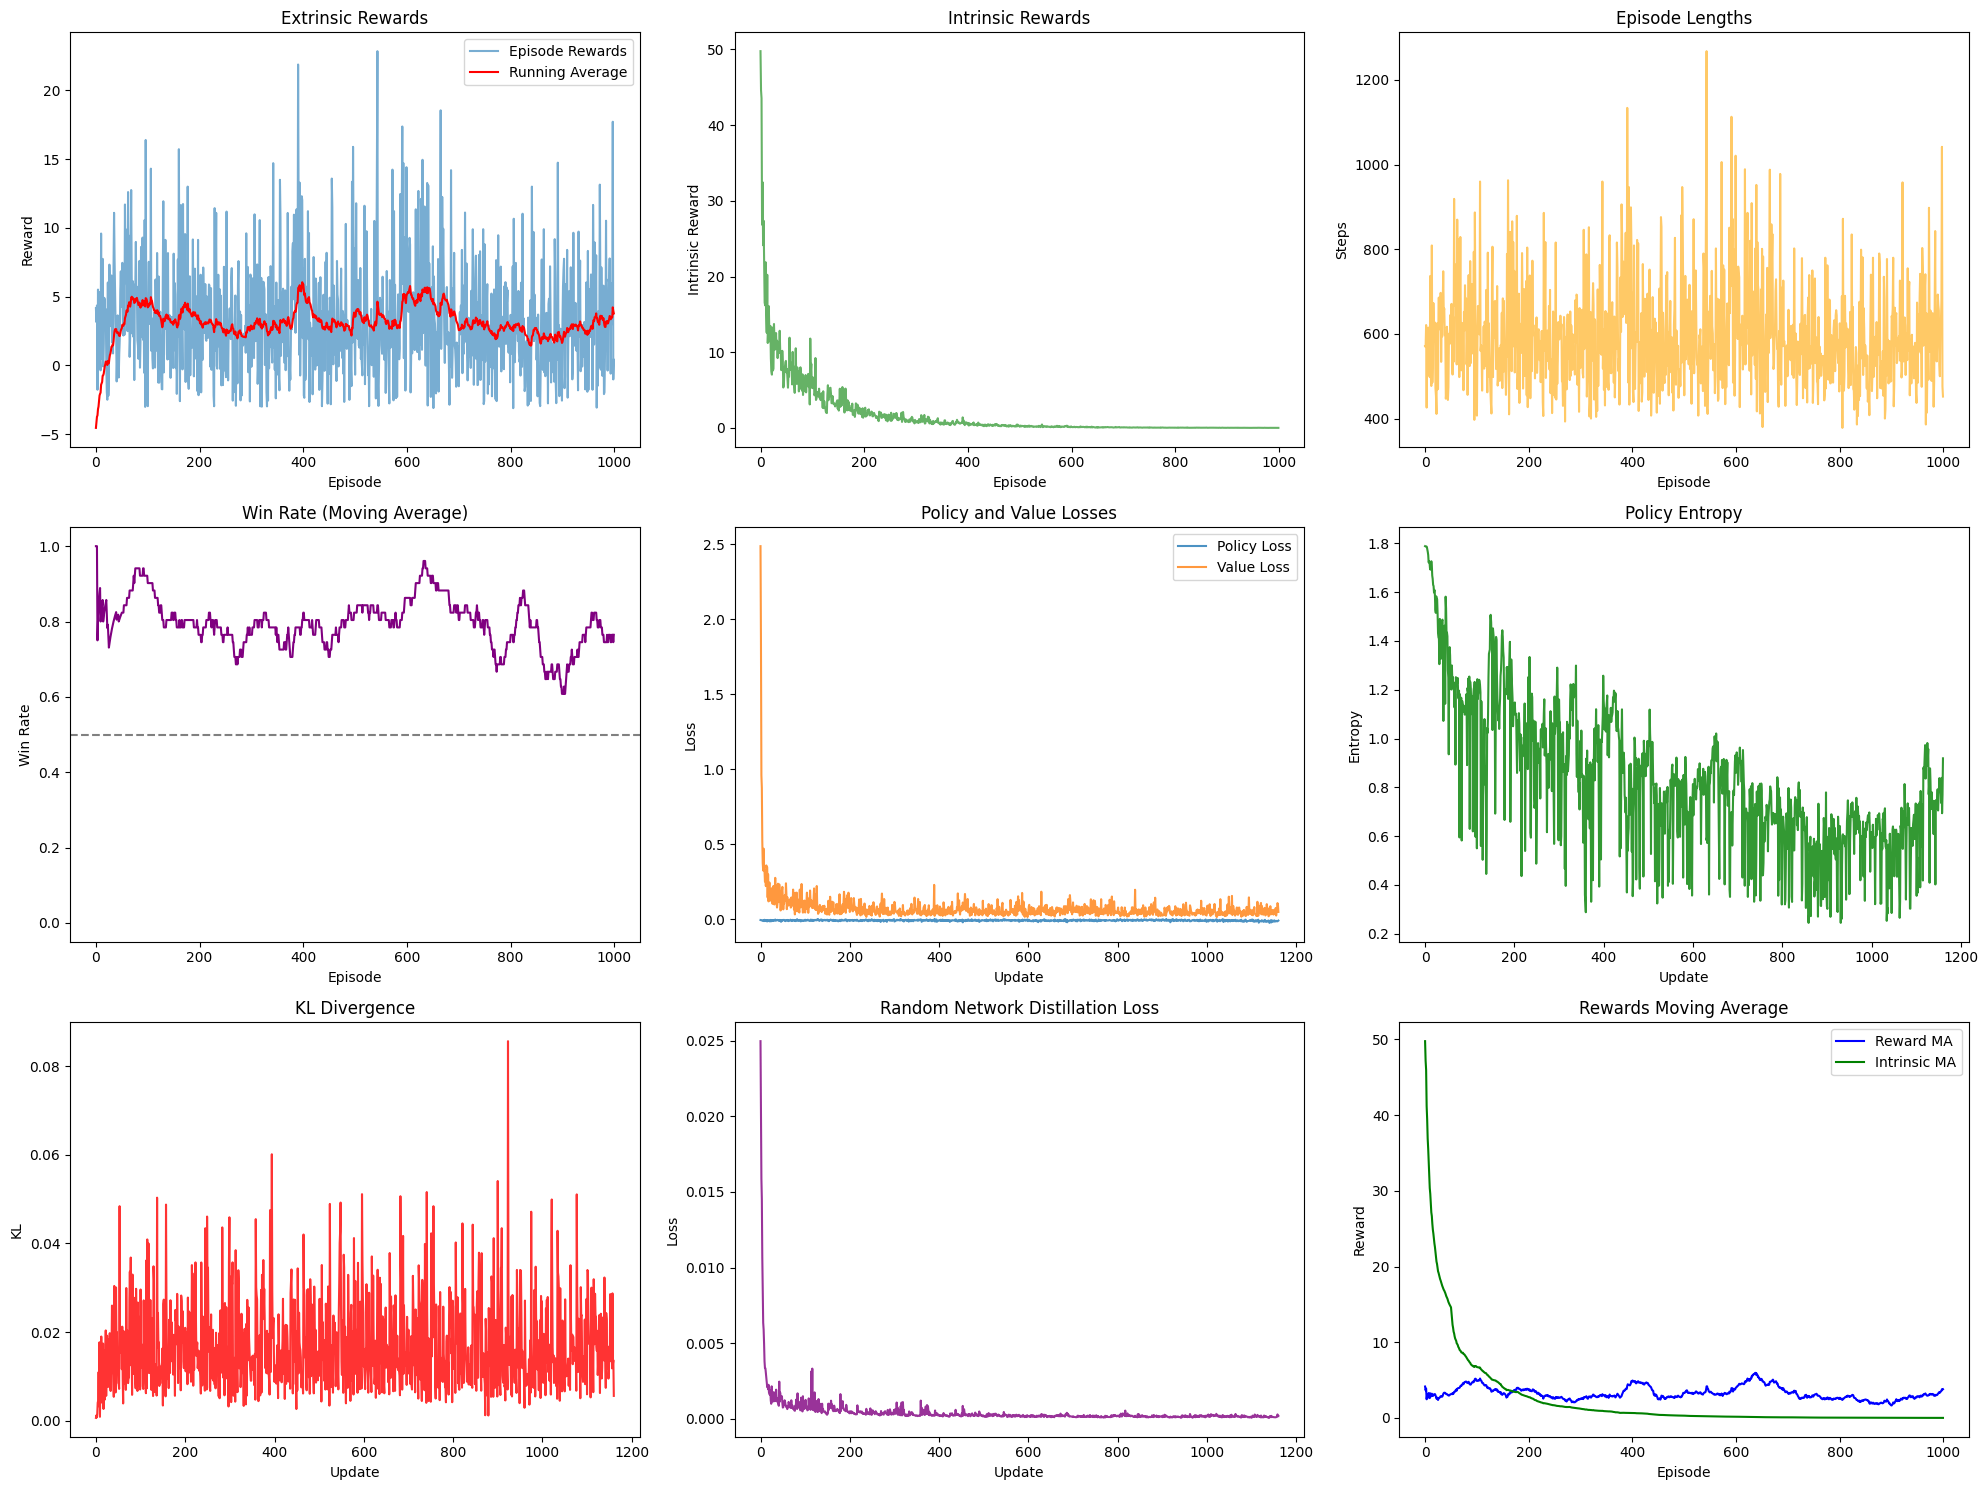


====== Training Metrics Report ======

--- Performance Metrics ---
Mean Reward: 3.30
Mean Reward (last 100 episodes): 3.33
Max Reward: 22.84
Min Reward: -3.11
Reward Std: 3.98
Reward Improvement: -0.75

Win Rate: 0.79
Win Rate (last 100 episodes): 0.78

Mean Episode Length: 594.92
Mean Episode Length (last 100): 598.16

Mean Ball Hits: 6.79
Mean Ball Hits (last 100): 6.64

--- Intrinsic Motivation Metrics ---
Mean Intrinsic Reward: 1.7157
Mean Intrinsic Reward (last 100): 0.0163
RND Loss Mean: 0.0005
RND Loss (last 100): 0.0002

--- Training Stability Metrics ---
Policy Loss Mean: -0.0068
Value Loss Mean: 0.0735
Entropy Mean: 0.8278
Entropy (last 100): 0.6803
KL Divergence Mean: 0.0171



Evaluating trained agent...
Evaluation episode 0/100, reward: -5.00
Evaluation episode 20/100, reward: -4.00
Evaluation episode 40/100, reward: -5.00
Evaluation episode 60/100, reward: -5.00
Evaluation episode 80/100, reward: -5.00

Evaluation Results:
Average reward: -4.88
Average episode length: 62

In [36]:
"""
Enhanced PPO implementation with Intrinsic Motivation for SlimeVolleyGym

This script implements a PPO agent with intrinsic motivation using:
1. Random Network Distillation (RND) for novelty-based exploration
2. Curriculum learning to gradually increase difficulty
3. Reward shaping to provide denser rewards
4. Enhanced metrics and visualization

Training runs for 1000 episodes instead of the original 5000.
"""

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import gym
import slimevolleygym
import matplotlib.pyplot as plt
import random
from collections import deque
import time
from tqdm.notebook import tqdm

class CompatibilityEnv(gym.Wrapper):
    """Wrapper to ensure environment compatibility across Gym versions"""
    def __init__(self, env):
        super().__init__(env)

    def reset(self):
        obs = self.env.reset()
        return np.array(obs, dtype=np.float32)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return np.array(obs, dtype=np.float32), reward, done, info

# Patch numpy for compatibility with SlimeVolleyGym
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.intrinsic_rewards = []
        self.is_terminals = []
        self.values = []

    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.intrinsic_rewards[:]
        del self.is_terminals[:]
        del self.values[:]

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(ActorCritic, self).__init__()

        # Shared feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh()
        )

        # Actor network - outputs action probabilities
        self.actor = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, action_dim)
        )

        # Critic network - outputs state value
        self.critic = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, state):
        features = self.feature_extractor(state)
        action_logits = self.actor(features)
        state_value = self.critic(features)
        return action_logits, state_value

    def act(self, state, memory=None):
        state = torch.FloatTensor(state).to(device)

        with torch.no_grad():
            action_logits, state_value = self.forward(state)
            action_probs = F.softmax(action_logits, dim=-1)
            dist = Categorical(action_probs)
            action = dist.sample()

        if memory is not None:
            memory.states.append(state)
            memory.actions.append(action)
            memory.logprobs.append(dist.log_prob(action))
            memory.values.append(state_value)

        return action.item()

    def evaluate(self, states, actions):
        action_logits, state_values = self.forward(states)
        action_probs = F.softmax(action_logits, dim=-1)
        dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(actions)
        dist_entropy = dist.entropy()

        return action_logprobs, torch.squeeze(state_values), dist_entropy

# Random Network Distillation (RND) for intrinsic motivation
class RNDModel(nn.Module):
    def __init__(self, state_dim, output_dim=128):
        super(RNDModel, self).__init__()

        # Target network (fixed random weights)
        self.target_network = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.Linear(256, output_dim)
        )

        # Predictor network (trained to predict target network)
        self.predictor_network = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.Linear(256, output_dim)
        )

        # Initialize target network with random weights (fixed)
        for param in self.target_network.parameters():
            param.requires_grad = False

    def forward(self, state):
        target_features = self.target_network(state)
        predicted_features = self.predictor_network(state)
        return target_features, predicted_features

    def calculate_intrinsic_reward(self, state):
        """Calculate intrinsic reward as the prediction error"""
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).to(device)
            target, prediction = self.forward(state_tensor)
            intrinsic_reward = torch.norm(target - prediction, dim=0, p=2).item()
        return intrinsic_reward

class PPO_IM:
    def __init__(self, state_dim, action_dim, hidden_dim=128, lr=3e-4,
                 gamma=0.99, eps_clip=0.2, K_epochs=4, entropy_coef=0.01,
                 value_coef=0.5, max_grad_norm=0.5, gae_lambda=0.95,
                 intrinsic_reward_coef=0.01, intrinsic_reward_decay=0.999):
        self.lr = lr
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.entropy_coef = entropy_coef
        self.value_coef = value_coef
        self.max_grad_norm = max_grad_norm
        self.gae_lambda = gae_lambda

        # Intrinsic motivation parameters
        self.intrinsic_reward_coef = intrinsic_reward_coef  # Weight for intrinsic rewards
        self.intrinsic_reward_decay = intrinsic_reward_decay  # Decay rate for intrinsic rewards

        self.policy = ActorCritic(state_dim, action_dim, hidden_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr)

        self.policy_old = ActorCritic(state_dim, action_dim, hidden_dim).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())

        # Initialize RND model for intrinsic motivation
        self.rnd_model = RNDModel(state_dim).to(device)
        self.rnd_optimizer = torch.optim.Adam(self.rnd_model.predictor_network.parameters(), lr=lr)

        self.MseLoss = nn.MSELoss()
        self.memory = Memory()

        # For adaptive KL divergence
        self.target_kl = 0.015
        self.adaptive_lr = True

        # Track metrics
        self.intrinsic_rewards = []
        self.extrinsic_rewards = []

        # Added epsilon attribute for evaluation compatibility
        self.epsilon = 0.0

    def select_action(self, state, deterministic=False):
        # Ensure state is float32
        state = np.array(state, dtype=np.float32)

        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).to(device)
            action_logits, _ = self.policy_old.forward(state_tensor)

            if deterministic:
                action_idx = torch.argmax(action_logits).item()
            else:
                action_probs = F.softmax(action_logits, dim=-1)
                dist = Categorical(action_probs)
                action_idx = dist.sample().item()

            # Convert discrete action to binary action
            return self._index_to_action(action_idx)

    def _index_to_action(self, action_idx):
        """Convert action index to binary action array for SlimeVolley"""
        if action_idx == 0:  # No-op
            return np.array([0, 0, 0])
        elif action_idx == 1:  # Forward
            return np.array([1, 0, 0])
        elif action_idx == 2:  # Forward + Jump
            return np.array([1, 0, 1])
        elif action_idx == 3:  # Jump
            return np.array([0, 0, 1])
        elif action_idx == 4:  # Backward + Jump
            return np.array([0, 1, 1])
        elif action_idx == 5:  # Backward
            return np.array([0, 1, 0])
        elif action_idx == 6:  # Forward + Backward (invalid, treat as no-op)
            return np.array([0, 0, 0])
        else:  # Anything else, treat as jump
            return np.array([0, 0, 1])

    def calculate_intrinsic_reward(self, state):
        """Calculate intrinsic reward based on RND prediction error"""
        intrinsic_reward = self.rnd_model.calculate_intrinsic_reward(state)
        # Normalize and scale intrinsic reward
        intrinsic_reward = min(intrinsic_reward * self.intrinsic_reward_coef, 1.0)
        return intrinsic_reward

    def update_rnd_model(self):
        """Update the RND predictor network"""
        # Collect all states from memory
        states = torch.stack(self.memory.states).detach()

        # Get target and predicted features
        target_features, predicted_features = self.rnd_model(states)

        # Compute prediction loss
        rnd_loss = self.MseLoss(predicted_features, target_features.detach())

        # Update predictor network
        self.rnd_optimizer.zero_grad()
        rnd_loss.backward()
        self.rnd_optimizer.step()

        return rnd_loss.item()

    def update(self):
        # Get old states, actions, etc.
        old_states = torch.stack(self.memory.states).detach()
        old_actions = torch.stack(self.memory.actions).detach()
        old_logprobs = torch.stack(self.memory.logprobs).detach()
        old_values = torch.stack(self.memory.values).detach().squeeze()

        # Calculate advantages using Generalized Advantage Estimation (GAE)
        advantages = []
        returns = []
        gae = 0

        # Process rewards - combine extrinsic and intrinsic rewards
        extrinsic_rewards = self.memory.rewards
        intrinsic_rewards = self.memory.intrinsic_rewards

        # Total rewards combines extrinsic and intrinsic rewards
        combined_rewards = [e + i for e, i in zip(extrinsic_rewards, intrinsic_rewards)]
        is_terminals = self.memory.is_terminals

        # Calculate returns with GAE
        for i in reversed(range(len(combined_rewards))):
            if i == len(combined_rewards) - 1 or is_terminals[i]:
                next_value = 0
            else:
                next_value = old_values[i + 1]

            delta = combined_rewards[i] + self.gamma * next_value * (1 - is_terminals[i]) - old_values[i]
            gae = delta + self.gamma * self.gae_lambda * (1 - is_terminals[i]) * gae

            advantages.insert(0, gae)
            returns.insert(0, gae + old_values[i])

        # Convert to tensors
        advantages = torch.tensor(advantages, dtype=torch.float).to(device)
        returns = torch.tensor(returns, dtype=torch.float).to(device)

        # Normalize advantages
        if len(advantages) > 1:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        # First update the RND model
        rnd_loss = self.update_rnd_model()

        # Optimize policy for K epochs
        total_policy_loss = 0
        total_value_loss = 0
        total_entropy = 0

        for _ in range(self.K_epochs):
            # Get current logprobs, state values, and entropy
            current_logprobs, current_state_values, entropy = self.policy.evaluate(old_states, old_actions)
            current_state_values = current_state_values.squeeze()

            # Compute ratios
            ratios = torch.exp(current_logprobs - old_logprobs)

            # Compute surrogate losses
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # Actor (policy) loss
            policy_loss = -torch.min(surr1, surr2).mean()

            # Value loss
            value_loss = self.MseLoss(current_state_values, returns)

            # Total loss
            loss = policy_loss + self.value_coef * value_loss - self.entropy_coef * entropy.mean()

            # Take gradient step
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
            self.optimizer.step()

            # Record losses for logging
            total_policy_loss += policy_loss.item()
            total_value_loss += value_loss.item()
            total_entropy += entropy.mean().item()

            # Calculate KL divergence
            with torch.no_grad():
                log_ratio = current_logprobs - old_logprobs
                approx_kl = torch.mean((torch.exp(log_ratio) - 1) - log_ratio).cpu().numpy()

            # Early stopping based on KL divergence
            if approx_kl > 1.5 * self.target_kl:
                break

        # Adjust learning rate based on KL
        if self.adaptive_lr and approx_kl > 2.0 * self.target_kl:
            self.lr = max(1e-6, self.lr * 0.9)
            self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=self.lr)
            self.rnd_optimizer = torch.optim.Adam(self.rnd_model.predictor_network.parameters(), lr=self.lr)
        elif self.adaptive_lr and approx_kl < 0.5 * self.target_kl:
            self.lr = min(1e-2, self.lr * 1.1)
            self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=self.lr)
            self.rnd_optimizer = torch.optim.Adam(self.rnd_model.predictor_network.parameters(), lr=self.lr)

        # Decay intrinsic reward coefficient
        self.intrinsic_reward_coef *= self.intrinsic_reward_decay

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # Clear memory
        self.memory.clear_memory()

        return {
            'policy_loss': total_policy_loss / self.K_epochs,
            'value_loss': total_value_loss / self.K_epochs,
            'entropy': total_entropy / self.K_epochs,
            'kl': approx_kl,
            'rnd_loss': rnd_loss
        }

    def save(self, filepath):
        torch.save({
            'policy_state_dict': self.policy.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'rnd_model_predictor_state_dict': self.rnd_model.predictor_network.state_dict(),
            'rnd_model_target_state_dict': self.rnd_model.target_network.state_dict(),
            'rnd_optimizer_state_dict': self.rnd_optimizer.state_dict(),
            'lr': self.lr,
            'intrinsic_reward_coef': self.intrinsic_reward_coef
        }, filepath)

    def load(self, filepath):
        checkpoint = torch.load(filepath, map_location=device)
        self.policy.load_state_dict(checkpoint['policy_state_dict'])
        self.policy_old.load_state_dict(checkpoint['policy_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.rnd_model.predictor_network.load_state_dict(checkpoint['rnd_model_predictor_state_dict'])
        self.rnd_model.target_network.load_state_dict(checkpoint['rnd_model_target_state_dict'])
        self.rnd_optimizer.load_state_dict(checkpoint['rnd_optimizer_state_dict'])
        self.lr = checkpoint['lr']
        self.intrinsic_reward_coef = checkpoint['intrinsic_reward_coef']

# Custom wrapper for reward shaping
class RewardShapingEnv(gym.Wrapper):
    def __init__(self, env, survival_bonus=0.01, ball_position_reward=True):
        super(RewardShapingEnv, self).__init__(env)
        self.survival_bonus = survival_bonus
        self.ball_position_reward = ball_position_reward
        self.last_ball_x = 0
        self.last_ball_y = 0

    def reset(self):
        obs = self.env.reset()
        # Extract ball position from observation
        self.last_ball_x = obs[4]  # ball_x
        self.last_ball_y = obs[5]  # ball_y
        return obs

    def step(self, action):
        obs, reward, done, info = self.env.step(action)

        shaped_reward = reward

        # Add survival bonus - small reward for lasting longer
        shaped_reward += self.survival_bonus

        # Add reward for hitting the ball (ball changed direction)
        if self.ball_position_reward:
            ball_x = obs[4]
            ball_y = obs[5]
            ball_vx = obs[6]

            # If ball is moving from left to right (positive vx), reward agent
            if ball_vx > 0 and self.last_ball_x < 0 and ball_x > self.last_ball_x:
                shaped_reward += 0.05

            # If ball is high, reward agent for positioning under it
            player_x = obs[0]
            if ball_y > 3.0 and abs(player_x - ball_x) < 1.0:
                shaped_reward += 0.01

            self.last_ball_x = ball_x
            self.last_ball_y = ball_y

        return obs, shaped_reward, done, info

# Custom wrapper for curriculum learning
class CurriculumEnv(gym.Wrapper):
    def __init__(self, env, initial_ball_speed=0.7, max_ball_speed=1.0, episodes_to_max=500):
        super(CurriculumEnv, self).__init__(env)
        self.initial_ball_speed = initial_ball_speed
        self.max_ball_speed = max_ball_speed
        self.episodes_to_max = episodes_to_max
        self.episode_count = 0
        self.current_ball_speed = initial_ball_speed

    def reset(self):
        obs = self.env.reset()

        # Update ball speed based on curriculum progress
        self.episode_count += 1
        progress = min(1.0, self.episode_count / self.episodes_to_max)
        self.current_ball_speed = self.initial_ball_speed + (self.max_ball_speed - self.initial_ball_speed) * progress

        # Note: In the SlimeVolley environment, we can't directly modify the ball speed
        # Instead, we'll track the curriculum progress for evaluation purposes
        # The observation already contains ball velocity information

        return obs

def debug_observations(model_path, num_steps=10):
    """Debug function to inspect observations and model behavior"""
    print("Loading model for debugging...")

    # Create standard environment
    standard_env = gym.make("SlimeVolley-v0")

    # Create wrapped environment
    wrapped_env = gym.make("SlimeVolley-v0")
    wrapped_env = CompatibilityEnv(wrapped_env)

    # Reset both environments
    standard_obs = standard_env.reset()
    wrapped_obs = wrapped_env.reset()

    # Comparing observations
    print(f"Standard observation type: {type(standard_obs)}, dtype: {standard_obs.dtype}")
    print(f"Wrapped observation type: {type(wrapped_obs)}, dtype: {wrapped_obs.dtype}")

    # Create agent
    state_dim = wrapped_env.observation_space.shape[0]
    action_dim = 6
    agent = PPO_IM(state_dim, action_dim)

    # Load model if it exists
    if os.path.exists(model_path):
        agent.load(model_path)
        print(f"Successfully loaded model from {model_path}")
    else:
        print(f"Warning: Model not found at {model_path}")

    # Test actions with both observation types
    print("\nTesting actions with different observation types:")

    # Using standard observation
    try:
        action_standard = agent.select_action(standard_obs)
        print(f"Action with standard observation: {action_standard}")
    except Exception as e:
        print(f"Error with standard observation: {e}")

    # Using wrapped observation
    try:
        action_wrapped = agent.select_action(wrapped_obs)
        print(f"Action with wrapped observation: {action_wrapped}")
    except Exception as e:
        print(f"Error with wrapped observation: {e}")

    # Test a few steps of interaction
    print("\nRunning a few interaction steps...")
    for i in range(num_steps):
        # Get action
        action = agent.select_action(wrapped_obs)

        # Step environment
        next_obs, reward, done, _ = wrapped_env.step(action)

        print(f"Step {i+1}: Action={action}, Reward={reward}, Done={done}")

        wrapped_obs = next_obs
        if done:
            wrapped_obs = wrapped_env.reset()
            print("Environment reset")

    return {
        "standard_obs_dtype": standard_obs.dtype,
        "wrapped_obs_dtype": wrapped_obs.dtype
    }

def train_ppo_im_with_curriculum(log_interval=20, max_episodes=1000, max_timesteps=3000,
                              update_timestep=512, save_dir="./ppo_im_models"):
    """Train a PPO agent with intrinsic motivation and curriculum learning."""

    # Create environment with curriculum learning and reward shaping
    env = gym.make("SlimeVolley-v0")
    env = CompatibilityEnv(env)  # Apply compatibility wrapper
    env = RewardShapingEnv(env, survival_bonus=0.005, ball_position_reward=True)
    env = CurriculumEnv(env, initial_ball_speed=0.7, max_ball_speed=1.0, episodes_to_max=500)

    # Get state and action dimensions
    state_dim = env.observation_space.shape[0]
    action_dim = 6  # We'll use 6 discrete actions

    # Setting up PPO agent with intrinsic motivation
    ppo_im = PPO_IM(state_dim, action_dim, hidden_dim=128, lr=3e-4,
               gamma=0.99, eps_clip=0.2, K_epochs=4,
               entropy_coef=0.01, value_coef=0.5,
               max_grad_norm=0.5, gae_lambda=0.95,
               intrinsic_reward_coef=0.05, intrinsic_reward_decay=0.995)

    # Create save directory
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Logging variables
    running_reward = -5.0
    running_intrinsic_reward = 0.0
    running_extrinsic_reward = 0.0
    avg_length = 0
    time_steps = 0
    i_episode = 0

    # Training loop
    episode_rewards = []
    episode_lengths = []
    episode_intrinsic_rewards = []
    episode_extrinsic_rewards = []
    avg_rewards = []
    avg_intrinsic_rewards = []
    losses = {'policy_loss': [], 'value_loss': [], 'entropy': [], 'kl': [], 'rnd_loss': []}

    # Additional metrics for final evaluation
    win_rate = []
    ball_hit_count = []

    pbar = tqdm(total=max_episodes)

    while i_episode < max_episodes:
        state = env.reset()
        episode_reward = 0
        episode_intrinsic_reward_sum = 0
        episode_extrinsic_reward_sum = 0
        episode_steps = 0
        ball_hits = 0
        # Extract ball velocity from observation instead of accessing directly
        # ball_x and ball_vx are indices 4 and 6 in the observation
        last_ball_vx = state[6]  # Extract ball velocity from observation

        for t in range(max_timesteps):
            time_steps += 1
            episode_steps += 1

            # Select action
            action_idx = ppo_im.policy_old.act(state, ppo_im.memory)
            action = ppo_im._index_to_action(action_idx)

            # Take action in environment
            next_state, extrinsic_reward, done, info = env.step(action)

            # Calculate intrinsic reward using RND
            intrinsic_reward = ppo_im.calculate_intrinsic_reward(state)

            # Store intrinsic and extrinsic rewards separately for tracking
            episode_intrinsic_reward_sum += intrinsic_reward
            episode_extrinsic_reward_sum += extrinsic_reward

            # Total reward = extrinsic + intrinsic
            combined_reward = extrinsic_reward + intrinsic_reward
            episode_reward += combined_reward

            # Track ball hits (when ball velocity changes)
            current_ball_vx = next_state[6]  # Extract ball velocity from observation
            if (last_ball_vx < 0 and current_ball_vx > 0) or (last_ball_vx > 0 and current_ball_vx < 0):
                ball_hits += 1
            last_ball_vx = current_ball_vx

            # Saving reward and is_terminal
            ppo_im.memory.rewards.append(extrinsic_reward)
            ppo_im.memory.intrinsic_rewards.append(intrinsic_reward)
            ppo_im.memory.is_terminals.append(done)

            # Update state
            state = next_state

            # Update if enough steps have been reached
            if time_steps % update_timestep == 0:
                update_info = ppo_im.update()
                for k, v in update_info.items():
                    if k in losses:
                        losses[k].append(v)

            if done or episode_steps >= max_timesteps:
                break

        # Update running metrics with exponential moving average
        running_reward = 0.05 * episode_extrinsic_reward_sum + (1 - 0.05) * running_reward
        running_intrinsic_reward = 0.05 * episode_intrinsic_reward_sum + (1 - 0.05) * running_intrinsic_reward
        running_extrinsic_reward = 0.05 * episode_extrinsic_reward_sum + (1 - 0.05) * running_extrinsic_reward
        avg_length = 0.05 * episode_steps + (1 - 0.05) * avg_length

        # Track win/loss for this episode
        won = episode_extrinsic_reward_sum > 0
        win_rate.append(1 if won else 0)
        ball_hit_count.append(ball_hits)

        # Store episode metrics
        episode_rewards.append(episode_extrinsic_reward_sum)
        episode_lengths.append(episode_steps)
        episode_intrinsic_rewards.append(episode_intrinsic_reward_sum)
        episode_extrinsic_rewards.append(episode_extrinsic_reward_sum)
        avg_rewards.append(running_reward)
        avg_intrinsic_rewards.append(running_intrinsic_reward)

        i_episode += 1

        # Update progress bar
        pbar.update(1)
        pbar.set_postfix(
            reward=f"{episode_extrinsic_reward_sum:.3f}",
            avg_reward=f"{running_reward:.3f}",
            ball_speed=f"{env.current_ball_speed:.2f}",
            intrinsic=f"{episode_intrinsic_reward_sum:.3f}"
        )

        # Log info
        if i_episode % log_interval == 0:
            recent_win_rate = np.mean(win_rate[-min(100, len(win_rate)):])
            print(f'Episode {i_episode} \t Reward: {episode_extrinsic_reward_sum:.2f} \t Avg reward: {running_reward:.2f} \t'
                  f'Length: {episode_steps} \t Ball speed: {env.current_ball_speed:.2f} \t'
                  f'Intrinsic: {episode_intrinsic_reward_sum:.3f} \t Win rate: {recent_win_rate:.2f}')

        # Save model periodically
        if i_episode % 200 == 0:
            ppo_im.save(f"{save_dir}/ppo_im_episode_{i_episode}.pth")

        # Save best model so far based on running reward
        if i_episode % 50 == 0:
            ppo_im.save(f"{save_dir}/ppo_im_best.pth")

    pbar.close()

    # Compute final metrics
    final_metrics = compute_final_metrics(
        episode_rewards, episode_lengths, episode_intrinsic_rewards,
        win_rate, ball_hit_count, losses
    )

    # Save final model
    ppo_im.save(f"{save_dir}/ppo_im_final.pth")

    # Plot training progress
    plot_training_metrics(
        episode_rewards, avg_rewards, episode_intrinsic_rewards,
        episode_lengths, losses, win_rate, save_dir
    )

    return ppo_im, final_metrics

def compute_final_metrics(rewards, lengths, intrinsic_rewards, win_rate, ball_hits, losses):
    """Compute comprehensive metrics at the end of training."""
    # Calculate moving windows to see trends
    window_size = min(100, len(rewards))

    # Performance metrics
    final_metrics = {
        'mean_reward': np.mean(rewards),
        'mean_reward_last_100': np.mean(rewards[-window_size:]),
        'max_reward': np.max(rewards),
        'min_reward': np.min(rewards),
        'std_reward': np.std(rewards),

        'mean_intrinsic_reward': np.mean(intrinsic_rewards),
        'mean_intrinsic_reward_last_100': np.mean(intrinsic_rewards[-window_size:]),

        'mean_episode_length': np.mean(lengths),
        'mean_episode_length_last_100': np.mean(lengths[-window_size:]),

        'overall_win_rate': np.mean(win_rate),
        'win_rate_last_100': np.mean(win_rate[-window_size:]),

        'mean_ball_hits': np.mean(ball_hits),
        'mean_ball_hits_last_100': np.mean(ball_hits[-window_size:]),

        # Training stability metrics
        'policy_loss_mean': np.mean(losses['policy_loss']),
        'policy_loss_std': np.std(losses['policy_loss']),
        'value_loss_mean': np.mean(losses['value_loss']),
        'value_loss_std': np.std(losses['value_loss']),
        'entropy_mean': np.mean(losses['entropy']),
        'entropy_last_100': np.mean(losses['entropy'][-min(100, len(losses['entropy'])):]),
        'kl_mean': np.mean(losses['kl']),
        'rnd_loss_mean': np.mean(losses['rnd_loss']),
        'rnd_loss_last_100': np.mean(losses['rnd_loss'][-min(100, len(losses['rnd_loss'])):]),
    }

    # Add reward improvement metric
    if len(rewards) > window_size:
        final_metrics['reward_improvement'] = (
            np.mean(rewards[-window_size:]) - np.mean(rewards[:window_size])
        )

    return final_metrics

def plot_training_metrics(rewards, avg_rewards, intrinsic_rewards, lengths, losses, win_rate, save_dir):
    """Create comprehensive visualizations of training progress."""
    plt.figure(figsize=(20, 15))

    # Plot rewards
    plt.subplot(3, 3, 1)
    plt.plot(rewards, alpha=0.6, label='Episode Rewards')
    plt.plot(avg_rewards, color='red', label='Running Average')
    plt.title('Extrinsic Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()

    # Plot intrinsic rewards
    plt.subplot(3, 3, 2)
    plt.plot(intrinsic_rewards, alpha=0.6, color='green')
    plt.title('Intrinsic Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Intrinsic Reward')

    # Plot episode lengths
    plt.subplot(3, 3, 3)
    plt.plot(lengths, alpha=0.6, color='orange')
    plt.title('Episode Lengths')
    plt.xlabel('Episode')
    plt.ylabel('Steps')

    # Plot win rate (moving average)
    plt.subplot(3, 3, 4)
    window_size = min(50, len(win_rate))
    win_rate_moving_avg = [np.mean(win_rate[max(0, i-window_size):i+1]) for i in range(len(win_rate))]
    plt.plot(win_rate_moving_avg, color='purple')
    plt.axhline(y=0.5, color='gray', linestyle='--')
    plt.title('Win Rate (Moving Average)')
    plt.xlabel('Episode')
    plt.ylabel('Win Rate')
    plt.ylim([-0.05, 1.05])

    # Plot policy and value losses
    plt.subplot(3, 3, 5)
    plt.plot(losses['policy_loss'], label='Policy Loss', alpha=0.8)
    plt.plot(losses['value_loss'], label='Value Loss', alpha=0.8)
    plt.title('Policy and Value Losses')
    plt.xlabel('Update')
    plt.ylabel('Loss')
    plt.legend()

    # Plot entropy
    plt.subplot(3, 3, 6)
    plt.plot(losses['entropy'], label='Entropy', color='green', alpha=0.8)
    plt.title('Policy Entropy')
    plt.xlabel('Update')
    plt.ylabel('Entropy')

    # Plot KL divergence
    plt.subplot(3, 3, 7)
    plt.plot(losses['kl'], label='KL Divergence', color='red', alpha=0.8)
    plt.title('KL Divergence')
    plt.xlabel('Update')
    plt.ylabel('KL')

    # Plot RND loss
    plt.subplot(3, 3, 8)
    plt.plot(losses['rnd_loss'], label='RND Loss', color='purple', alpha=0.8)
    plt.title('Random Network Distillation Loss')
    plt.xlabel('Update')
    plt.ylabel('Loss')

    # Plot combined metrics
    plt.subplot(3, 3, 9)
    window_size = min(50, len(rewards))
    reward_ma = [np.mean(rewards[max(0, i-window_size):i+1]) for i in range(len(rewards))]
    intrinsic_ma = [np.mean(intrinsic_rewards[max(0, i-window_size):i+1]) for i in range(len(intrinsic_rewards))]

    plt.plot(reward_ma, label='Reward MA', color='blue')
    plt.plot(intrinsic_ma, label='Intrinsic MA', color='green')
    plt.title('Rewards Moving Average')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{save_dir}/training_metrics.png", dpi=300)
    plt.show()

def evaluate_policy(env_name, policy, episodes=100, render=False):
    """Evaluate a trained policy over multiple episodes."""
    # Create environment with compatibility wrapper
    env = gym.make(env_name)
    env = CompatibilityEnv(env)  # Apply compatibility wrapper

    rewards = []
    lengths = []
    win_count = 0

    for i in range(episodes):
        state = env.reset()
        episode_reward = 0
        episode_length = 0
        done = False

        while not done:
            # Ensure we're using deterministic actions
            action = policy.select_action(state, deterministic=True)

            # Step the environment
            state, reward, done, _ = env.step(action)
            episode_reward += reward
            episode_length += 1

            if render and i < 5:  # Only render a few episodes
                try:
                    env.render()
                    time.sleep(0.01)
                except Exception as e:
                    print(f"Rendering error: {e}")

        rewards.append(episode_reward)
        lengths.append(episode_length)
        if episode_reward > 0:
            win_count += 1

        if i % 20 == 0:
            print(f"Evaluation episode {i}/{episodes}, reward: {episode_reward:.2f}")

    win_rate = win_count / episodes
    avg_reward = np.mean(rewards)
    avg_length = np.mean(lengths)

    print(f"\nEvaluation Results:")
    print(f"Average reward: {avg_reward:.2f}")
    print(f"Average episode length: {avg_length:.2f}")
    print(f"Win rate: {win_rate:.2f}")

    return {
        'avg_reward': avg_reward,
        'avg_length': avg_length,
        'win_rate': win_rate,
        'rewards': rewards
    }

def play_against_baseline(agent, episodes=5, render=True):
    """Let the human watch the agent play against baseline."""
    try:
        # Try new Gym API first
        env = gym.make("SlimeVolley-v0", render_mode='human')
        print("Using new Gym API with render_mode")
    except TypeError:
        # Fall back to old API
        env = gym.make("SlimeVolley-v0")
        print("Using old Gym API")

    env = CompatibilityEnv(env)  # Apply compatibility wrapper

    # Add missing epsilon attribute if needed
    if not hasattr(agent, 'epsilon'):
        print("Adding missing epsilon attribute to agent")
        agent.epsilon = 0.0

    for episode in range(episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        step = 0

        while not done:
            # Get agent's action (playing as right agent)
            action = agent.select_action(state, deterministic=True)

            # Take step
            state, reward, done, _ = env.step(action)
            episode_reward += reward
            step += 1

            if render:
                try:
                    env.render()
                    time.sleep(0.01)
                except Exception as e:
                    print(f"Rendering error: {e}")
                    render = False  # Disable rendering if it fails

        print(f"Episode {episode+1}: Reward = {episode_reward:.3f}, Steps = {step}")

    env.close()

def format_metrics_report(metrics):
    """Format the metrics for nice printing."""
    report = "\n====== Training Metrics Report ======\n"

    report += "\n--- Performance Metrics ---\n"
    report += f"Mean Reward: {metrics['mean_reward']:.2f}\n"
    report += f"Mean Reward (last 100 episodes): {metrics['mean_reward_last_100']:.2f}\n"
    report += f"Max Reward: {metrics['max_reward']:.2f}\n"
    report += f"Min Reward: {metrics['min_reward']:.2f}\n"
    report += f"Reward Std: {metrics['std_reward']:.2f}\n"

    if 'reward_improvement' in metrics:
        report += f"Reward Improvement: {metrics['reward_improvement']:.2f}\n"

    report += f"\nWin Rate: {metrics['overall_win_rate']:.2f}\n"
    report += f"Win Rate (last 100 episodes): {metrics['win_rate_last_100']:.2f}\n"

    report += f"\nMean Episode Length: {metrics['mean_episode_length']:.2f}\n"
    report += f"Mean Episode Length (last 100): {metrics['mean_episode_length_last_100']:.2f}\n"

    report += f"\nMean Ball Hits: {metrics['mean_ball_hits']:.2f}\n"
    report += f"Mean Ball Hits (last 100): {metrics['mean_ball_hits_last_100']:.2f}\n"

    report += "\n--- Intrinsic Motivation Metrics ---\n"
    report += f"Mean Intrinsic Reward: {metrics['mean_intrinsic_reward']:.4f}\n"
    report += f"Mean Intrinsic Reward (last 100): {metrics['mean_intrinsic_reward_last_100']:.4f}\n"
    report += f"RND Loss Mean: {metrics['rnd_loss_mean']:.4f}\n"
    report += f"RND Loss (last 100): {metrics['rnd_loss_last_100']:.4f}\n"

    report += "\n--- Training Stability Metrics ---\n"
    report += f"Policy Loss Mean: {metrics['policy_loss_mean']:.4f}\n"
    report += f"Value Loss Mean: {metrics['value_loss_mean']:.4f}\n"
    report += f"Entropy Mean: {metrics['entropy_mean']:.4f}\n"
    report += f"Entropy (last 100): {metrics['entropy_last_100']:.4f}\n"
    report += f"KL Divergence Mean: {metrics['kl_mean']:.4f}\n"

    report += "\n============================\n"

    return report

def main():
    print("Main function started...")

    # Check if environment can be created
    try:
        test_env = gym.make("SlimeVolley-v0")
        print(f"Successfully created test environment: {test_env}")
    except Exception as e:
        print(f"Error creating environment: {e}")

    # Set seeds for reproducibility
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # Set save directory
    save_dir = "./ppo_im_slimevolley"
    model_path = f"{save_dir}/ppo_im_best.pth"

    # Check if model exists
    if os.path.exists(model_path):
        print(f"Existing model found at {model_path}")
        # Debug observations to understand any type mismatches
        print("\nRunning observation debug...")
        debug_results = debug_observations(model_path)
        print(f"Debug results: {debug_results}")

    # Train PPO agent with intrinsic motivation and curriculum learning
    print("Starting PPO with Intrinsic Motivation training...")
    ppo_im, metrics = train_ppo_im_with_curriculum(
        max_episodes=1000,  # Reduced from 5000 to 1000
        update_timestep=512,
        save_dir=save_dir
    )

    # Print metrics report
    print(format_metrics_report(metrics))

    # Save metrics to file
    with open(f"{save_dir}/training_metrics.txt", 'w') as f:
        f.write(format_metrics_report(metrics))

    # Evaluate trained agent
    print("\nEvaluating trained agent...")
    eval_results = evaluate_policy("SlimeVolley-v0", ppo_im, episodes=100, render=False)

    # Save evaluation results
    with open(f"{save_dir}/evaluation_results.txt", 'w') as f:
        f.write(f"Evaluation Results:\n")
        f.write(f"Average reward: {eval_results['avg_reward']:.2f}\n")
        f.write(f"Average episode length: {eval_results['avg_length']:.2f}\n")
        f.write(f"Win rate: {eval_results['win_rate']:.2f}\n")

    # Watch agent play
    print("\nWatching agent play against baseline...")
    play_against_baseline(ppo_im, episodes=5, render=True)

# Add an explicit main() call at the end
if __name__ == "__main__":
    try:
        print("Execution starting...")
        main()
        print("Execution completed successfully!")
    except Exception as e:
        import traceback
        print(f"ERROR: {e}")
        print(traceback.format_exc())
        print("Execution failed with the above error.")



In [39]:
!pip install colab_env

  Preparing metadata (setup.py) ... done
  Created wheel for colab_env: filename=colab_env-0.2.0-py3-none-any.whl size=3805 sha256=e85347cd801572795004b0c9a48a96d23109eaf654d9339f339f4e41b365521c
  Stored in directory: /root/.cache/pip/wheels/bb/c6/c1/a7eaa7b4cb2f3bdd1a32ff68d7f83d3e44b40483f9aa9ca51e
Successfully built colab_env


Visualizing trained PPO model with Intrinsic Motivation
Loading model from ./ppo_im_slimevolley/ppo_im_best.pth
Successfully loaded model from ./ppo_im_slimevolley/ppo_im_best.pth
Episode 1/3
Episode 1 reward: -5.00, steps: 728
Episode 2/3
Episode 2 reward: -5.00, steps: 633
Episode 3/3
Episode 3 reward: -5.00, steps: 586

Average episode reward: -5.00
Win rate: 0.00

Visualizing agent behavior through state plots...


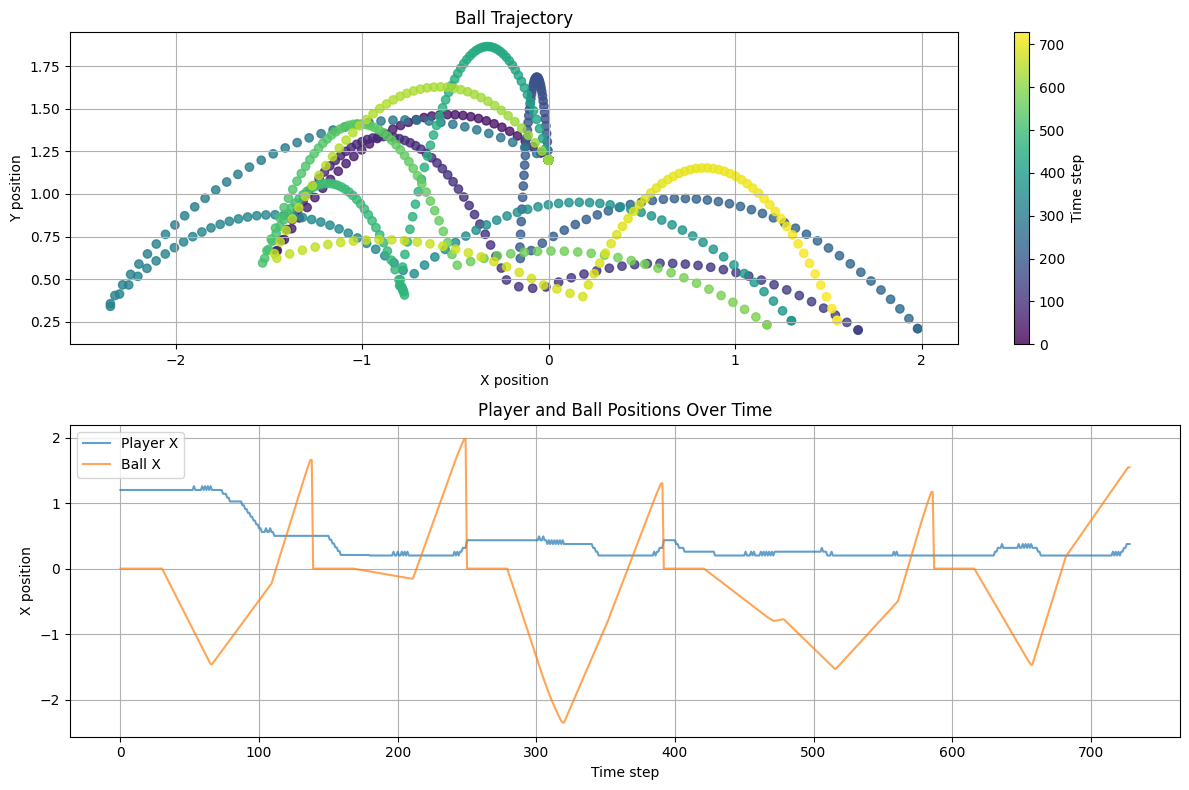

Visualizing trained PPO model with Intrinsic Motivation
Loading model from ./ppo_im_slimevolley/ppo_im_best.pth
Successfully loaded model from ./ppo_im_slimevolley/ppo_im_best.pth
Episode 1/3
Episode 1 reward: -5.00, steps: 412
Episode 2/3
Episode 2 reward: -5.00, steps: 667
Episode 3/3
Episode 3 reward: -5.00, steps: 662

Average episode reward: -5.00
Win rate: 0.00

Visualizing agent behavior through state plots...


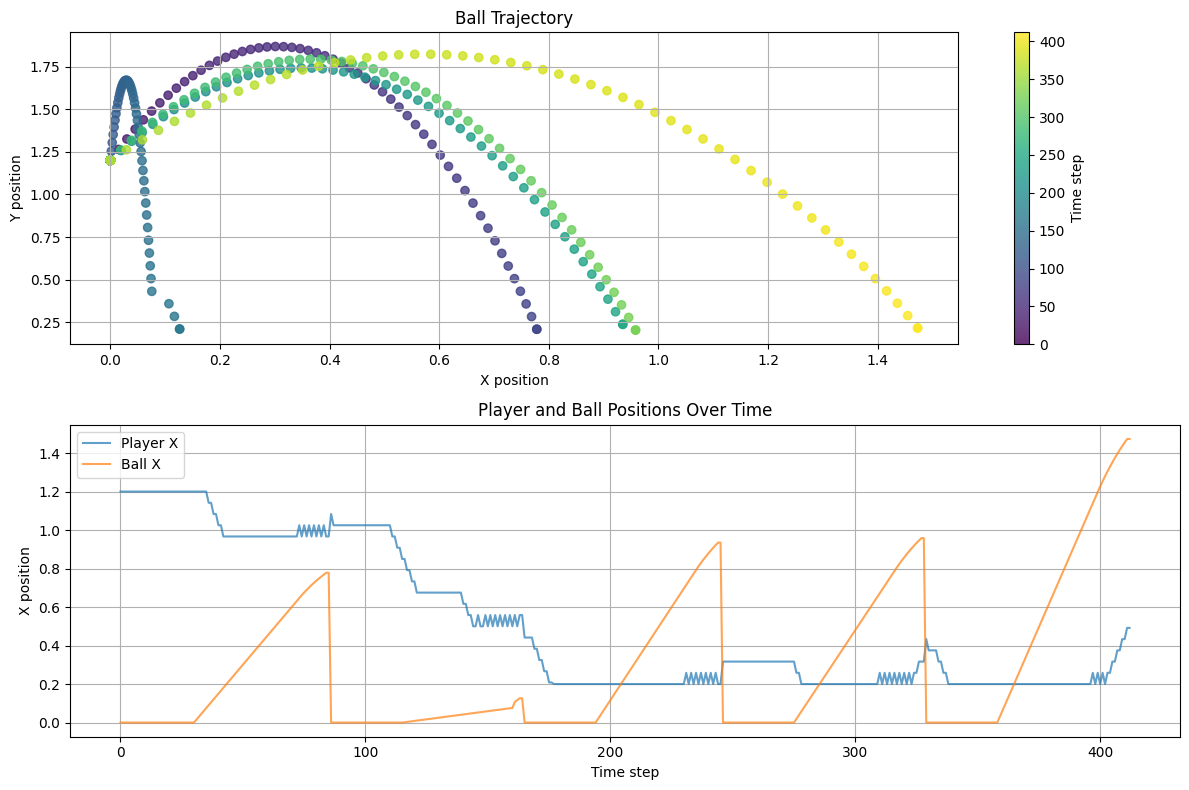


Visualizing network architecture...

Network Architecture:

Feature Extractor:
0.weight: torch.Size([128, 12])
0.bias: torch.Size([128])
2.weight: torch.Size([128, 128])
2.bias: torch.Size([128])

Actor Network:
0.weight: torch.Size([128, 128])
0.bias: torch.Size([128])
2.weight: torch.Size([6, 128])
2.bias: torch.Size([6])

Critic Network:
0.weight: torch.Size([128, 128])
0.bias: torch.Size([128])
2.weight: torch.Size([1, 128])
2.bias: torch.Size([1])

RND Target Network:
0.weight: torch.Size([256, 12])
0.bias: torch.Size([256])
2.weight: torch.Size([256, 256])
2.bias: torch.Size([256])
4.weight: torch.Size([128, 256])
4.bias: torch.Size([128])

RND Predictor Network:
0.weight: torch.Size([256, 12])
0.bias: torch.Size([256])
2.weight: torch.Size([256, 256])
2.bias: torch.Size([256])
4.weight: torch.Size([128, 256])
4.bias: torch.Size([128])

Total trainable parameters in policy network: 52103
Total trainable parameters in RND predictor network: 102016
Total trainable parameters: 1541

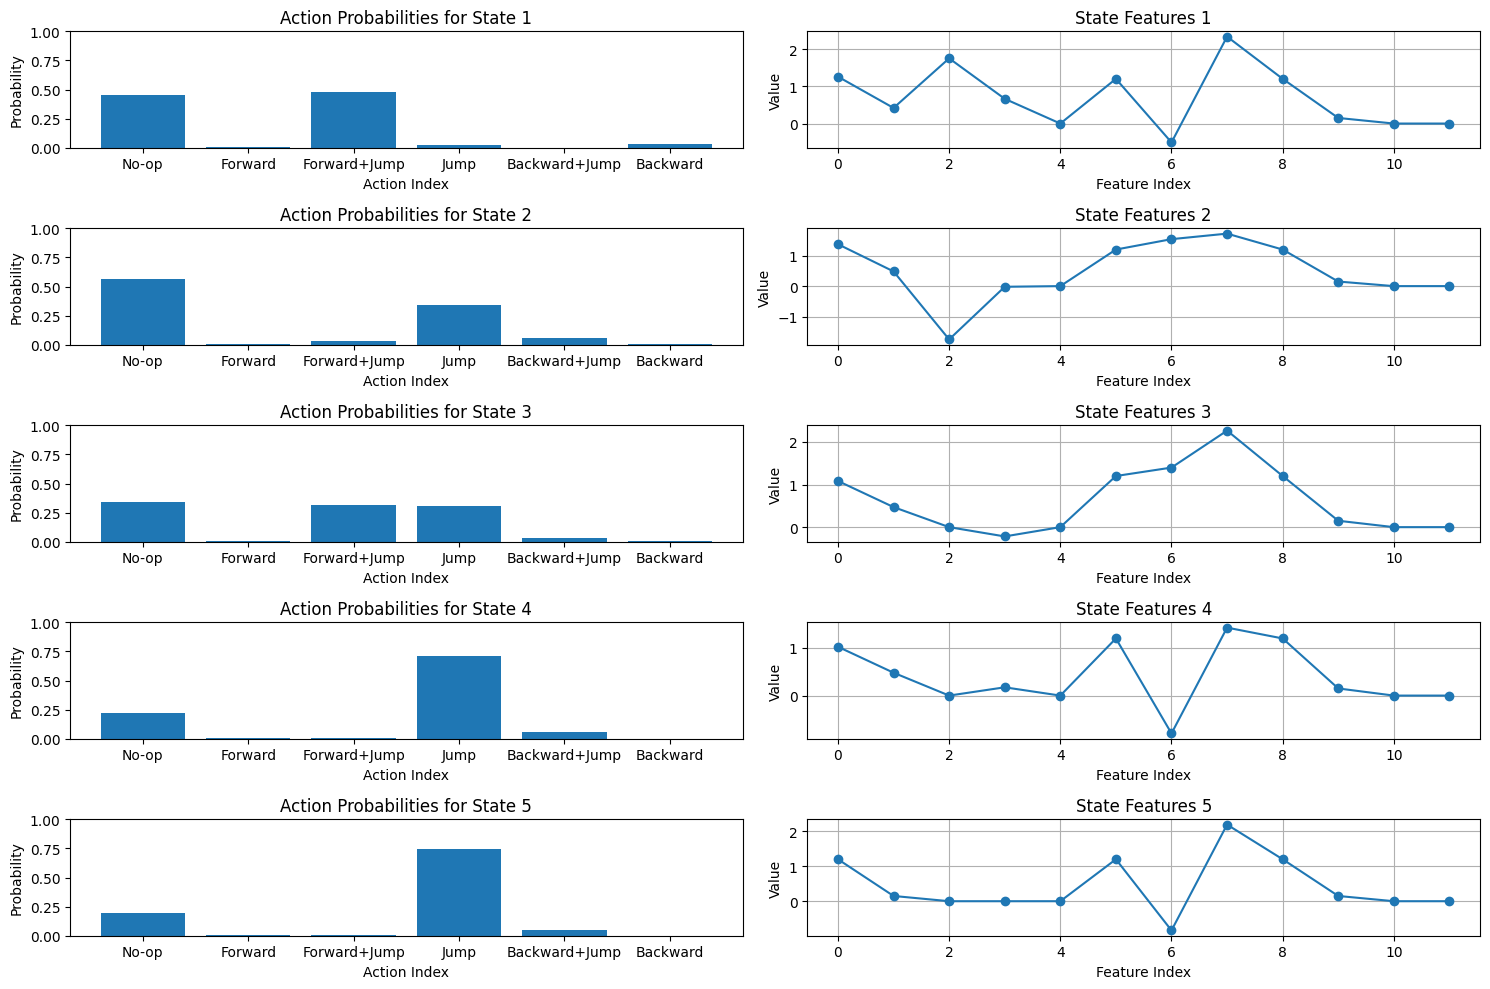

In [48]:
# Model Visualization for PPO with Intrinsic Motivation
# Run this in a separate cell after the main code

import torch
import numpy as np
import matplotlib.pyplot as plt
import gym
import slimevolleygym
from matplotlib import animation
from IPython.display import HTML, display
import os
import pyglet

# Patch the rendering issue in SlimeVolleyGym
# This fixes the "cannot import name 'rendering'" error
import slimevolleygym.slimevolley as sv
# Override the checkRendering function to avoid the import error
def patched_check_rendering():
    pass
sv.checkRendering = patched_check_rendering

# Use the existing CompatibilityEnv wrapper
# (This is already defined in the main code)

def visualize_trained_model(model_path="./ppo_im_slimevolley/ppo_im_best.pth",
                           num_episodes=3, max_steps=1000):
    """
    Visualize the trained model in action using text-based representation instead of rendering
    """
    print(f"Loading model from {model_path}")

    # Create environment with compatibility wrapper
    env = gym.make("SlimeVolley-v0")
    env = CompatibilityEnv(env)

    # Get state dimensions
    state_dim = env.observation_space.shape[0]
    action_dim = 6  # Same as in the original code

    # Create agent instance
    agent = PPO_IM(state_dim, action_dim)

    # Check if model exists
    if os.path.exists(model_path):
        agent.load(model_path)
        print(f"Successfully loaded model from {model_path}")
    else:
        print(f"Model not found at {model_path}, using random policy")

    # Play episodes
    episode_rewards = []

    # Simplified visualization - states history instead of frames
    all_states = []
    all_actions = []

    for episode in range(num_episodes):
        print(f"Episode {episode+1}/{num_episodes}")
        state = env.reset()
        episode_reward = 0
        steps = 0

        # Store state history for this episode
        episode_states = [state.copy()]
        episode_actions = []

        while steps < max_steps:
            # Select action
            action = agent.select_action(state, deterministic=True)

            # Take step
            state, reward, done, _ = env.step(action)
            episode_reward += reward
            steps += 1

            # Store state and action
            episode_states.append(state.copy())
            episode_actions.append(action)

            if done:
                break

        all_states.append(episode_states)
        all_actions.append(episode_actions)
        episode_rewards.append(episode_reward)
        print(f"Episode {episode+1} reward: {episode_reward:.2f}, steps: {steps}")

    env.close()

    # Display statistics
    print(f"\nAverage episode reward: {np.mean(episode_rewards):.2f}")
    print(f"Win rate: {sum(r > 0 for r in episode_rewards) / len(episode_rewards):.2f}")

    # Visualize game states (instead of rendering)
    print("\nVisualizing agent behavior through state plots...")

    # Pick the first episode for visualization
    states_to_plot = all_states[0]
    actions_to_plot = all_actions[0]

    # Plot the ball trajectory
    plt.figure(figsize=(12, 8))

    # Extract ball positions from states
    ball_x = [state[4] for state in states_to_plot]  # ball_x is at index 4
    ball_y = [state[5] for state in states_to_plot]  # ball_y is at index 5

    # Extract player positions
    player_x = [state[0] for state in states_to_plot]  # player_x is at index 0
    player_y = [state[1] for state in states_to_plot]  # player_y is at index 1

    # Plot ball trajectory
    plt.subplot(2, 1, 1)
    plt.scatter(ball_x, ball_y, c=np.arange(len(ball_x)), cmap='viridis', alpha=0.8)
    plt.colorbar(label='Time step')
    plt.title('Ball Trajectory')
    plt.xlabel('X position')
    plt.ylabel('Y position')
    plt.grid(True)

    # Plot player and ball x positions over time
    plt.subplot(2, 1, 2)
    plt.plot(player_x, label='Player X', alpha=0.7)
    plt.plot(ball_x, label='Ball X', alpha=0.7)
    plt.title('Player and Ball Positions Over Time')
    plt.xlabel('Time step')
    plt.ylabel('X position')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return agent, episode_rewards

# Function to visualize agent's policy
def visualize_policy(agent, num_states=5):
    """
    Visualize the policy by showing action probabilities for random states
    """
    # Create environment to sample states
    env = gym.make("SlimeVolley-v0")
    env = CompatibilityEnv(env)

    plt.figure(figsize=(15, 10))

    for i in range(num_states):
        # Get a random state
        state = env.reset()

        # Move a few random steps to get varied states
        for _ in range(np.random.randint(0, 20)):
            random_action = env.action_space.sample()
            state, _, done, _ = env.step(random_action)
            if done:
                state = env.reset()

        # Get action probabilities from policy
        state_tensor = torch.FloatTensor(state).to(device)
        with torch.no_grad():
            action_logits, _ = agent.policy.forward(state_tensor)
            action_probs = torch.nn.functional.softmax(action_logits, dim=-1).cpu().numpy()

        # Plot
        plt.subplot(num_states, 2, i*2+1)
        plt.bar(range(6), action_probs.flatten())
        plt.title(f'Action Probabilities for State {i+1}')
        plt.xlabel('Action Index')
        plt.ylabel('Probability')
        plt.xticks(range(6), ['No-op', 'Forward', 'Forward+Jump', 'Jump', 'Backward+Jump', 'Backward'])
        plt.ylim(0, 1)

        # Visualize the state
        plt.subplot(num_states, 2, i*2+2)
        plt.plot(state, 'o-')
        plt.title(f'State Features {i+1}')
        plt.xlabel('Feature Index')
        plt.ylabel('Value')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

# Function to visualize value function
def visualize_value_function(agent, num_states=100):
    """
    Visualize the value function by plotting state values for random states
    """
    # Create environment to sample states
    env = gym.make("SlimeVolley-v0")
    env = CompatibilityEnv(env)

    states = []
    values = []

    # Collect states and their values
    for _ in range(num_states):
        state = env.reset()
        states.append(state)

        # Get state value from critic
        state_tensor = torch.FloatTensor(state).to(device)
        with torch.no_grad():
            _, state_value = agent.policy.forward(state_tensor)
            values.append(state_value.item())

    # Sort by value for better visualization
    sorted_indices = np.argsort(values)
    sorted_values = [values[i] for i in sorted_indices]

    plt.figure(figsize=(10, 6))
    plt.plot(sorted_values, 'o-')
    plt.title('State Value Distribution')
    plt.xlabel('State Index (sorted by value)')
    plt.ylabel('State Value')
    plt.grid(True)
    plt.show()

    # Show value distribution histogram
    plt.figure(figsize=(10, 6))
    plt.hist(values, bins=20)
    plt.title('State Value Histogram')
    plt.xlabel('State Value')
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()

# Function to visualize intrinsic rewards
def visualize_intrinsic_rewards(agent, num_states=100):
    """
    Visualize the intrinsic rewards for different states
    """
    # Create environment to sample states
    env = gym.make("SlimeVolley-v0")
    env = CompatibilityEnv(env)

    states = []
    intrinsic_rewards = []

    # Collect states and their intrinsic rewards
    for _ in range(num_states):
        state = env.reset()
        states.append(state)

        # Get intrinsic reward
        intrinsic_reward = agent.calculate_intrinsic_reward(state)
        intrinsic_rewards.append(intrinsic_reward)

    # Sort by intrinsic reward for better visualization
    sorted_indices = np.argsort(intrinsic_rewards)
    sorted_rewards = [intrinsic_rewards[i] for i in sorted_indices]

    plt.figure(figsize=(10, 6))
    plt.plot(sorted_rewards, 'o-')
    plt.title('Intrinsic Reward Distribution')
    plt.xlabel('State Index (sorted by intrinsic reward)')
    plt.ylabel('Intrinsic Reward')
    plt.grid(True)
    plt.show()

    # Show intrinsic reward distribution histogram
    plt.figure(figsize=(10, 6))
    plt.hist(intrinsic_rewards, bins=20)
    plt.title('Intrinsic Reward Histogram')
    plt.xlabel('Intrinsic Reward')
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()

# Run the visualizations
print("Visualizing trained PPO model with Intrinsic Motivation")
agent, rewards = visualize_trained_model()

# Add a simple function to visualize network architecture
def visualize_network_architecture(agent):
    """
    Visualize the neural network architecture of the PPO model
    """
    print("\nNetwork Architecture:")
    print("\nFeature Extractor:")
    for name, param in agent.policy.feature_extractor.named_parameters():
        print(f"{name}: {param.shape}")

    print("\nActor Network:")
    for name, param in agent.policy.actor.named_parameters():
        print(f"{name}: {param.shape}")

    print("\nCritic Network:")
    for name, param in agent.policy.critic.named_parameters():
        print(f"{name}: {param.shape}")

    print("\nRND Target Network:")
    for name, param in agent.rnd_model.target_network.named_parameters():
        print(f"{name}: {param.shape}")

    print("\nRND Predictor Network:")
    for name, param in agent.rnd_model.predictor_network.named_parameters():
        print(f"{name}: {param.shape}")

    # Calculate and print total parameters
    total_params = sum(p.numel() for p in agent.policy.parameters() if p.requires_grad)
    total_rnd_params = sum(p.numel() for p in agent.rnd_model.predictor_network.parameters() if p.requires_grad)
    print(f"\nTotal trainable parameters in policy network: {total_params}")
    print(f"Total trainable parameters in RND predictor network: {total_rnd_params}")
    print(f"Total trainable parameters: {total_params + total_rnd_params}")

# Run only the essential visualizations to avoid rendering issues
print("Visualizing trained PPO model with Intrinsic Motivation")
agent, rewards = visualize_trained_model()

# Visualize the network architecture (doesn't require rendering)
print("\nVisualizing network architecture...")
visualize_network_architecture(agent)

# Visualize policy (this should work without rendering)
print("\nVisualizing policy...")
visualize_policy(agent)